# Setup

In [0]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
from torchtext import datasets

import urllib.request

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from ast import literal_eval
import spacy

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_data = pd.read_csv('drive/Shared drives/CS229Movie/train1.csv')
valid_data = pd.read_csv('drive/Shared drives/CS229Movie/valid1.csv')
test_data = pd.read_csv('drive/Shared drives/CS229Movie/test1.csv')

In [5]:
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)
train_X = train_data.drop(columns=['posterID','IMDBscore'])
valid_X = valid_data.drop(columns=['posterID','IMDBscore'])
test_X = test_data.drop(columns=['posterID','IMDBscore'])

(13600, 6018)
(2914, 6018)
(2915, 6018)


# Random Forest Parameter Test

In [0]:
from sklearn.ensemble import RandomForestRegressor

rfreg = RandomForestRegressor(max_depth=32, random_state=0,n_estimators=100)
rfreg.fit(train_X, train_data['IMDBscore'])

print('Train R^2: ', rfreg.score(train_X, train_data['IMDBscore']))
print('Train MSE: ', mean_squared_error(rfreg.predict(train_X), train_data['IMDBscore']))

print('Valid R^2: ', rfreg.score(valid_X, valid_data['IMDBscore']))
print('Valid MSE: ', mean_squared_error(rfreg.predict(valid_X), valid_data['IMDBscore']))

print('Test R^2: ', rfreg.score(test_X, test_data['IMDBscore']))
print('Test MSE: ', mean_squared_error(rfreg.predict(test_X), test_data['IMDBscore']))

Train R^2:  0.8819486896127308
Train MSE:  0.17646090005485182
Valid R^2:  0.4157589134771039
Valid MSE:  0.8719259619493909
Test R^2:  0.4253214943373195
Test MSE:  0.8546312379882001


#### test on tree number (n_estimator)

In [0]:
train_R2_list = []
train_MSE_list = []

dev_R2_list = []
dev_MSE_list = []

time_list = [] # seconds

tree_number_range = list(range(1, 10, 2)) + list(range(10, 50, 5)) + list(range(50, 160, 10))
# max_depth_range = range(18) * 5 + 10

for n in tree_number_range:
  print(n)
  start_time = time.time()
  rfreg = RandomForestRegressor(max_depth=32, random_state=0,n_estimators=n)
  rfreg.fit(train_X, train_data['IMDBscore'])

  time_list.append(time.time() - start_time)

  train_R2_list.append(rfreg.score(train_X, train_data['IMDBscore']))
  train_MSE_list.append(mean_squared_error(rfreg.predict(train_X), train_data['IMDBscore']))

  dev_R2_list.append(rfreg.score(valid_X, valid_data['IMDBscore']))
  dev_MSE_list.append(mean_squared_error(rfreg.predict(valid_X), valid_data['IMDBscore']))

para_test_nestimator = {
    'train_R2_list': train_R2_list,
    'train_MSE_list': train_MSE_list,
    'dev_R2_list': dev_R2_list,
    'dev_MSE_list': dev_MSE_list,
    'time_list': time_list
}

1
3
5
7
9
10
15
20
25
30
35
40
45
50
60
70
80
90
100
110
120
130
140
150


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


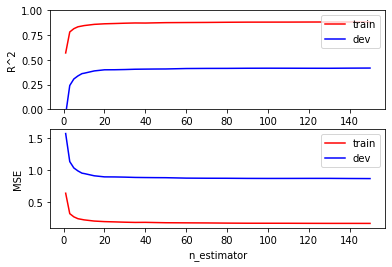

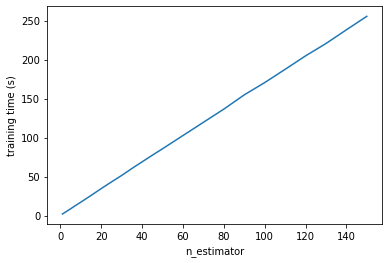

In [0]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(tree_number_range, train_R2_list, color = 'red', label = 'train')
ax1.plot(tree_number_range, dev_R2_list, color = 'blue', label = 'dev')
ax1.legend(loc='upper right')

# ax1.set_xlabel('n_estimator')
ax1.set_ylabel('R^2')
# ax1.set_xlim([0, 200])
ax1.set_ylim([0, 1])

ax2.plot(tree_number_range, train_MSE_list, color = 'red', label = 'train')
ax2.plot(tree_number_range, dev_MSE_list, color = 'blue', label = 'dev')
ax2.legend(loc='upper right')

ax2.set_xlabel('n_estimator')
ax2.set_ylabel('MSE')
# ax2.set_xlim([0, 200])
# ax2.set_ylim([0, 1.2])
fig.show()


fig0, ax0 = plt.subplots()
ax0.plot(tree_number_range, time_list)
ax0.set_xlabel('n_estimator')
ax0.set_ylabel('training time (s)')
fig0.show()

fig.savefig('drive/Shared drives/CS229Movie/RandomForest_nestimator.eps')
fig0.savefig('drive/Shared drives/CS229Movie/RandomForest_nestimator_traintime.eps')

#### test on max depth

In [0]:
# set tree number to 100
train_R2_list = []
train_MSE_list = []

dev_R2_list = []
dev_MSE_list = []

time_list = [] # seconds

# max_depth_range = list(range(1, 10, 2)) + list(range(10, 50, 5)) + list(range(50, 130, 10))
max_depth_range = list(range(10, 101, 5))

for d in max_depth_range:
  print(d)
  start_time = time.time()
  rfreg = RandomForestRegressor(max_depth=d, random_state=0,n_estimators=100)
  rfreg.fit(train_X, train_data['IMDBscore'])

  time_list.append(time.time() - start_time)

  train_R2_list.append(rfreg.score(train_X, train_data['IMDBscore']))
  train_MSE_list.append(mean_squared_error(rfreg.predict(train_X), train_data['IMDBscore']))

  dev_R2_list.append(rfreg.score(valid_X, valid_data['IMDBscore']))
  dev_MSE_list.append(mean_squared_error(rfreg.predict(valid_X), valid_data['IMDBscore']))

para_test_maxdepth = {
    'train_R2_list': train_R2_list,
    'train_MSE_list': train_MSE_list,
    'dev_R2_list': dev_R2_list,
    'dev_MSE_list': dev_MSE_list,
    'time_list': time_list
}

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


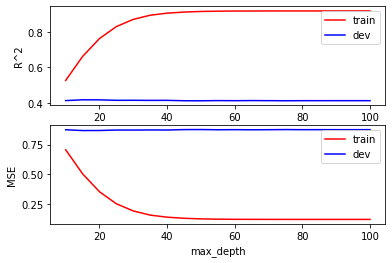

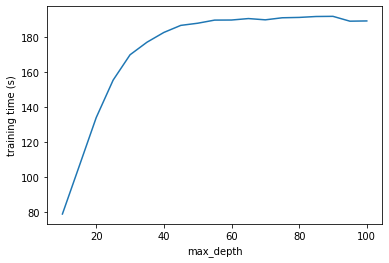

In [0]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(max_depth_range, train_R2_list, color = 'red', label = 'train')
ax1.plot(max_depth_range, dev_R2_list, color = 'blue', label = 'dev')
ax1.legend(loc='upper right')

# ax1.set_xlabel('n_estimator')
ax1.set_ylabel('R^2')
# ax1.set_xlim([0, 200])
# ax1.set_ylim([0, 1])

ax2.plot(max_depth_range, train_MSE_list, color = 'red', label = 'train')
ax2.plot(max_depth_range, dev_MSE_list, color = 'blue', label = 'dev')
ax2.legend(loc='upper right')

ax2.set_xlabel('max_depth')
ax2.set_ylabel('MSE')
# ax2.set_xlim([0, 200])
# ax2.set_ylim([0, 1.2])
fig.show()


fig0, ax0 = plt.subplots()
ax0.plot(max_depth_range, time_list)
ax0.set_xlabel('max_depth')
ax0.set_ylabel('training time (s)')
fig0.show()


fig.savefig('drive/Shared drives/CS229Movie/RandomForest_maxdepth.eps')
fig0.savefig('drive/Shared drives/CS229Movie/RandomForest_maxdepth_traintime.eps')

In [0]:
# set tree number to 5
train_R2_list = []
train_MSE_list = []

dev_R2_list = []
dev_MSE_list = []

time_list = [] # seconds

# max_depth_range = list(range(1, 10, 2)) + list(range(10, 50, 5)) + list(range(50, 130, 10))
max_depth_range = list(range(10, 101, 5))

for d in max_depth_range:
  print(d)
  start_time = time.time()
  rfreg = RandomForestRegressor(max_depth=d, random_state=0,n_estimators=5)
  rfreg.fit(train_X, train_data['IMDBscore'])

  time_list.append(time.time() - start_time)

  train_R2_list.append(rfreg.score(train_X, train_data['IMDBscore']))
  train_MSE_list.append(mean_squared_error(rfreg.predict(train_X), train_data['IMDBscore']))

  dev_R2_list.append(rfreg.score(valid_X, valid_data['IMDBscore']))
  dev_MSE_list.append(mean_squared_error(rfreg.predict(valid_X), valid_data['IMDBscore']))

para_test_maxdepth = {
    'train_R2_list': train_R2_list,
    'train_MSE_list': train_MSE_list,
    'dev_R2_list': dev_R2_list,
    'dev_MSE_list': dev_MSE_list,
    'time_list': time_list
}

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


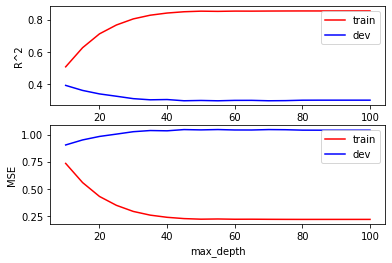

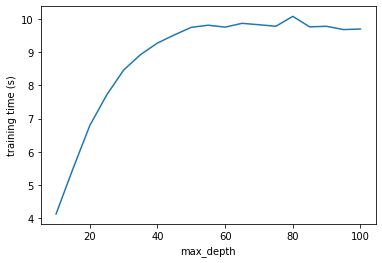

In [0]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(max_depth_range, train_R2_list, color = 'red', label = 'train')
ax1.plot(max_depth_range, dev_R2_list, color = 'blue', label = 'dev')
ax1.legend(loc='upper right')

# ax1.set_xlabel('n_estimator')
ax1.set_ylabel('R^2')
# ax1.set_xlim([0, 200])
# ax1.set_ylim([0, 1])

ax2.plot(max_depth_range, train_MSE_list, color = 'red', label = 'train')
ax2.plot(max_depth_range, dev_MSE_list, color = 'blue', label = 'dev')
ax2.legend(loc='upper right')

ax2.set_xlabel('max_depth')
ax2.set_ylabel('MSE')
# ax2.set_xlim([0, 200])
# ax2.set_ylim([0, 1.2])
fig.show()


fig0, ax0 = plt.subplots()
ax0.plot(max_depth_range, time_list)
ax0.set_xlabel('max_depth')
ax0.set_ylabel('training time (s)')
fig0.show()


fig.savefig('drive/Shared drives/CS229Movie/RandomForest_maxdepth_tree5.eps')
fig0.savefig('drive/Shared drives/CS229Movie/RandomForest_maxdepth_tree5_traintime.eps')

In [0]:
# set tree number to 1
train_R2_list = []
train_MSE_list = []

dev_R2_list = []
dev_MSE_list = []

time_list = [] # seconds

# max_depth_range = list(range(1, 10, 2)) + list(range(10, 50, 5)) + list(range(50, 130, 10))
max_depth_range = list(range(10, 101, 5))

for d in max_depth_range:
  print(d)
  start_time = time.time()
  rfreg = RandomForestRegressor(max_depth=d, random_state=0,n_estimators=1)
  rfreg.fit(train_X, train_data['IMDBscore'])

  time_list.append(time.time() - start_time)

  train_R2_list.append(rfreg.score(train_X, train_data['IMDBscore']))
  train_MSE_list.append(mean_squared_error(rfreg.predict(train_X), train_data['IMDBscore']))

  dev_R2_list.append(rfreg.score(valid_X, valid_data['IMDBscore']))
  dev_MSE_list.append(mean_squared_error(rfreg.predict(valid_X), valid_data['IMDBscore']))

para_test_maxdepth = {
    'train_R2_list': train_R2_list,
    'train_MSE_list': train_MSE_list,
    'dev_R2_list': dev_R2_list,
    'dev_MSE_list': dev_MSE_list,
    'time_list': time_list
}

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


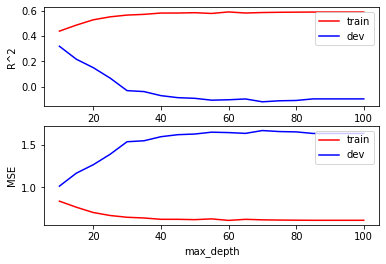

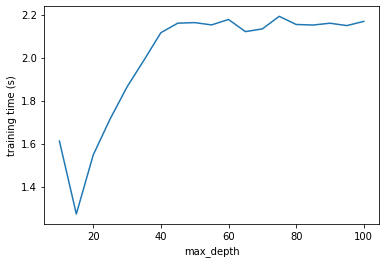

In [0]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(max_depth_range, train_R2_list, color = 'red', label = 'train')
ax1.plot(max_depth_range, dev_R2_list, color = 'blue', label = 'dev')
ax1.legend(loc='upper right')

# ax1.set_xlabel('n_estimator')
ax1.set_ylabel('R^2')
# ax1.set_xlim([0, 200])
# ax1.set_ylim([0, 1])

ax2.plot(max_depth_range, train_MSE_list, color = 'red', label = 'train')
ax2.plot(max_depth_range, dev_MSE_list, color = 'blue', label = 'dev')
ax2.legend(loc='upper right')

ax2.set_xlabel('max_depth')
ax2.set_ylabel('MSE')
# ax2.set_xlim([0, 200])
# ax2.set_ylim([0, 1.2])
fig.show()


fig0, ax0 = plt.subplots()
ax0.plot(max_depth_range, time_list)
ax0.set_xlabel('max_depth')
ax0.set_ylabel('training time (s)')
fig0.show()

fig.savefig('drive/Shared drives/CS229Movie/RandomForest_maxdepth_tree1.eps')
fig0.savefig('drive/Shared drives/CS229Movie/RandomForest_maxdepth_tree1_traintime.eps')

#### test on max feature (fraction of total features)

In [0]:
train_R2_list = []
train_MSE_list = []

dev_R2_list = []
dev_MSE_list = []

max_feature_range = list(np.arange(0.1, 1.1, 0.1))

for f in max_feature_range:
  print(f)
  rfreg = RandomForestRegressor(max_depth=32, random_state=0,n_estimators=100, max_features=f)
  rfreg.fit(train_X, train_data['IMDBscore'])

  train_R2_list.append(rfreg.score(train_X, train_data['IMDBscore']))
  train_MSE_list.append(mean_squared_error(rfreg.predict(train_X), train_data['IMDBscore']))

  dev_R2_list.append(rfreg.score(valid_X, valid_data['IMDBscore']))
  dev_MSE_list.append(mean_squared_error(rfreg.predict(valid_X), valid_data['IMDBscore']))

para_test_maxfeature = {
    'range': max_feature_range,
    'train_R2_list': train_R2_list,
    'train_MSE_list': train_MSE_list,
    'dev_R2_list': dev_R2_list,
    'dev_MSE_list': dev_MSE_list
}

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


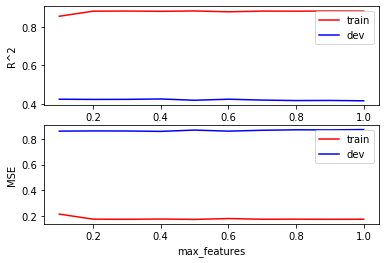

In [0]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(max_feature_range, train_R2_list, color = 'red', label = 'train')
ax1.plot(max_feature_range, dev_R2_list, color = 'blue', label = 'dev')
ax1.legend(loc='upper right')

ax1.set_ylabel('R^2')
# ax1.set_xlim([0, 200])
# ax1.set_ylim([0, 1])

ax2.plot(max_feature_range, train_MSE_list, color = 'red', label = 'train')
ax2.plot(max_feature_range, dev_MSE_list, color = 'blue', label = 'dev')
ax2.legend(loc='upper right')

ax2.set_xlabel('max_features')
ax2.set_ylabel('MSE')
# ax2.set_xlim([0, 200])
# ax2.set_ylim([0, 1.2])
fig.show()

fig.savefig('drive/Shared drives/CS229Movie/RandomForest_maxfeature.eps')

# Feature Importance

#### access dictionary

In [0]:
def get_words(message, tokenizer = None):
    if tokenizer:
        doc = tokenizer(message)
        return [i.text for i in doc]
    else:
        return message.lower().split('|')

def create_dictionary(messages, min_count = 5, tokenizer = None):
    words_count = {}
    for s in messages:
        words = get_words(s, tokenizer)
        words_unique = list(dict.fromkeys(words))
        for w in words_unique:
            if w not in words_count:
                words_count[w] = 1
            else:
                words_count[w] += 1

    for word in list(words_count.keys()):
        if words_count[word] < min_count:
            del words_count[word]

    index = 1
    for word in list(words_count.keys()):
        words_count[word] = index
        index = index + 1

    return words_count

In [7]:
train_data_fordict = pd.read_csv('drive/Shared drives/CS229Movie/train.csv')

genre_dictionary = create_dictionary(train_data_fordict['genre'].astype(str).values, min_count=5)
print('Size of dictionary: ', len(genre_dictionary))

director_dictionary = create_dictionary(train_data_fordict['director'].astype(str).values, min_count=5)
print('Size of dictionary: ', len(director_dictionary))

actors_dictionary = create_dictionary(train_data_fordict['actors'].astype(str).values, min_count = 5)
print('Size of dictionary: ', len(actors_dictionary))

tokenizer = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])
overview_dictionary = create_dictionary(train_data_fordict['overview'], min_count = 20, tokenizer = tokenizer)
print('Size of dictionary: ', len(overview_dictionary))

poster_feature_list = ['num_faces','hue','hue_sd','saturation','saturation_sd ','brightness','brightness_sd','blue','blue_sd','green','green_sd','red','red_sd ']
print('length of list:', len(poster_feature_list))

Size of dictionary:  23
Size of dictionary:  492
Size of dictionary:  1603
Size of dictionary:  3884
length of list: 13


In [13]:
if 'ruoyun ma' in actors_dictionary:
  print('yes')
else:
  print('no')

no


In [17]:
if 'steven spielberg' in director_dictionary:
  print('yes')
else:
  print('no')

yes


#### feature importance categorization

In [18]:
from sklearn.ensemble import RandomForestRegressor

rfreg = RandomForestRegressor(max_depth=32, random_state=0,n_estimators=100)
rfreg.fit(train_X, train_data['IMDBscore'])

print('Train R^2: ', rfreg.score(train_X, train_data['IMDBscore']))
print('Train MSE: ', mean_squared_error(rfreg.predict(train_X), train_data['IMDBscore']))

print('Valid R^2: ', rfreg.score(valid_X, valid_data['IMDBscore']))
print('Valid MSE: ', mean_squared_error(rfreg.predict(valid_X), valid_data['IMDBscore']))

print('Test R^2: ', rfreg.score(test_X, test_data['IMDBscore']))
print('Test MSE: ', mean_squared_error(rfreg.predict(test_X), test_data['IMDBscore']))

Train R^2:  0.8819486896127308
Train MSE:  0.17646090005485182
Valid R^2:  0.4157589134771039
Valid MSE:  0.8719259619493909
Test R^2:  0.4253214943373195
Test MSE:  0.8546312379882001


In [0]:
importances = rfreg.feature_importances_
indices = np.argsort(importances)[::-1]
feature_name = train_X.columns

importances_order = np.argsort(rfreg.feature_importances_)[::-1]

In [16]:
genre_indices = []
director_indices = []
actor_indices = []
overview_indices = []
poster_indices = []

for idx in indices:
  if feature_name[idx] in genre_dictionary:
    genre_indices.append(idx)
  elif feature_name[idx] in director_dictionary:
    director_indices.append(idx)
  elif feature_name[idx] in actors_dictionary:
    actor_indices.append(idx)
  elif feature_name[idx] in overview_dictionary:
    overview_indices.append(idx)
  elif feature_name[idx] in poster_feature_list:
    poster_indices.append(idx)

print(len(genre_indices), len(director_indices), len(actor_indices), len(overview_indices), len(poster_indices))

23 491 1578 3862 8


Director Feature Importance Ranking (Top 10):
1 documentary 0.1422441944794736
2 runtime 0.1327596730068581
3 horror 0.08357367135793568
4 drama 0.0509635843000348
5 saturation_sd 0.03726235389791489
6 hue_sd 0.03671717250534032
7 hue 0.03492230459809001
8 saturation 0.034029880672423594
9 blue_sd 0.03002757317940987
10 green_sd 0.028504360681907443


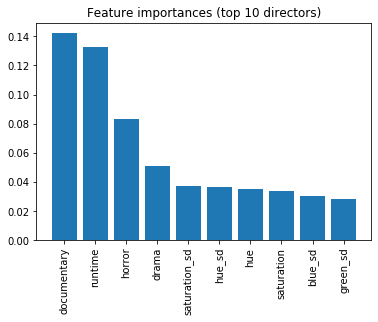

Index(['documentary', 'runtime', 'horror', 'drama', 'saturation_sd', 'hue_sd',
       'hue', 'saturation', 'blue_sd', 'green_sd', 'red_sd', 'brightness_sd',
       'red', 'green', 'blue', 'brightness', 'animation', 'action', 'short',
       'sci-fi'],
      dtype='object')
[0.14224419 0.13275967 0.08357367 0.05096358 0.03726235 0.03671717
 0.0349223  0.03402988 0.03002757 0.02850436 0.02790697 0.02731554
 0.02706554 0.02588318 0.02568622 0.02454099 0.02124341 0.02060925
 0.01014084 0.00833281]


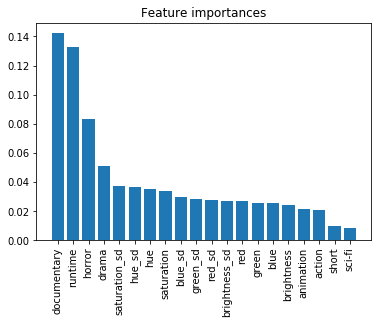

In [0]:
print("Director Feature Importance Ranking (Top 10):")

for f in range(10):
  idx = indices[f]
  print(f + 1, feature_name[idx], importances[idx])

plt.figure()
plt.title("Feature importances (top 10 directors)")
plt.bar(range(10),importances[indices[:10]])
plt.xticks(range(10), feature_name[indices[:10]], rotation='vertical')
plt.show()

importances_order = np.argsort(rfreg.feature_importances_)[::-1]
print(train_X.columns[importances_order[:20]])
print(rfreg.feature_importances_[importances_order[:20]])
plt.figure()
plt.title("Feature importances")
plt.bar(range(20),rfreg.feature_importances_[importances_order[:20]])
plt.xticks(range(20), train_X.columns[importances_order[:20]], rotation='vertical')
plt.show()

Poster Feature Importance Ranking:
1 hue_sd 0.03671717250534032
2 hue 0.03492230459809001
3 saturation 0.034029880672423594
4 blue_sd 0.03002757317940987
5 green_sd 0.028504360681907443
6 brightness_sd 0.027315537339223074
7 brightness 0.024540990816510115
8 num_faces 0.008283618392189851


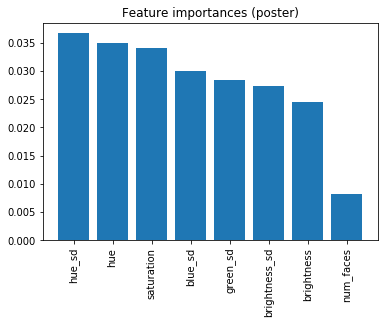

<Figure size 432x288 with 0 Axes>

In [0]:
print("Poster Feature Importance Ranking:")

for f in range(len(poster_indices)):
  idx = poster_indices[f]
  print(f + 1, feature_name[idx], importances[idx])

plt.figure()
plt.title("Feature importances (poster)")
plt.bar(range(len(poster_indices)),importances[poster_indices])
plt.xticks(range(len(poster_indices)), feature_name[poster_indices], rotation='vertical')
plt.show()
plt.savefig('drive/Shared drives/CS229Movie/FeatureImportance_Poster.eps')

Genre Feature Importance Ranking:
1 documentary 0.1422441944794736
2 horror 0.08357367135793568
3 drama 0.0509635843000348
4 animation 0.021243406070119673
5 action 0.02060925186900123
6 short 0.010140839489348307
7 sci-fi 0.00833280769543361
8 thriller 0.00830863813429401
9 comedy 0.006180394618029642
10 crime 0.004709173612929041
11 adventure 0.003271587046211919
12 biography 0.003183456566605228
13 mystery 0.0029485530220315125
14 romance 0.0027203695885681303
15 fantasy 0.002637091222969429
16 music 0.002036027079664268
17 family 0.00189648319848737
18 musical 0.0009429844328922936
19 sport 0.0009014956412851991
20 history 0.0008984612598376572
21 war 0.0006373527543911793
22 western 0.0004053054800323349
23 news 0.0001095808878631754


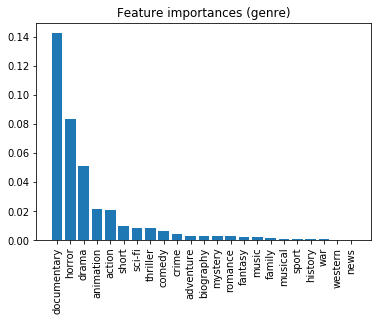

<Figure size 432x288 with 0 Axes>

In [0]:
print("Genre Feature Importance Ranking:")

for f in range(len(genre_indices)):
  idx = genre_indices[f]
  print(f + 1, feature_name[idx], importances[idx])

plt.figure()
plt.title("Feature importances (genre)")
plt.bar(range(len(genre_indices)),importances[genre_indices])
plt.xticks(range(len(genre_indices)), feature_name[genre_indices], rotation='vertical')
plt.show()
plt.savefig('drive/Shared drives/CS229Movie/FeatureImportance_Genre.eps')

Director Feature Importance Ranking (Top 10):
1 tyler perry 0.0016153423253181093
2 woody allen 0.0013275135221576238
3 craig moss 0.0011491057419322458
4 uwe boll 0.0007764900611206415
5 steven r. monroe 0.0006314454310220677
6 stewart raffill 0.0005907426818814123
7 sean mcnamara 0.0005705326715050454
8 fred olen ray 0.0005605291142887452
9 tom clegg 0.0005477865868557429
10 don michael paul 0.0004849788851569984


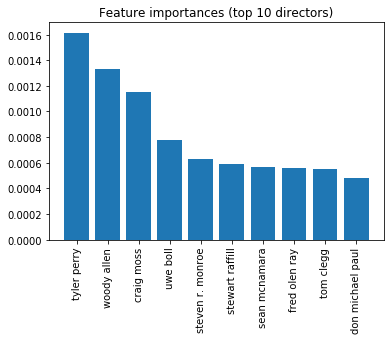

<Figure size 432x288 with 0 Axes>

In [0]:
print("Director Feature Importance Ranking (Top 10):")

for f in range(10):
  idx = director_indices[f]
  print(f + 1, feature_name[idx], importances[idx])

plt.figure()
plt.title("Feature importances (top 10 directors)")
plt.bar(range(10),importances[director_indices[:10]])
plt.xticks(range(10), feature_name[director_indices[:10]], rotation='vertical')
plt.show()
plt.savefig('drive/Shared drives/CS229Movie/FeatureImportance_Director.eps')

Actor Feature Importance Ranking (Top 10):
1 stephen baldwin 0.00097372918681564
2 thomas kretschmann 0.0009596875256154656
3 lauren bacall 0.0008026018153381338
4 manisha koirala 0.0007703100595298186
5 angie everhart 0.0006715889036562849
6 mischa barton 0.0006677503468590948
7 kirk cameron 0.0006317293873173731
8 daragh o'malley 0.000609087608756056
9 joel david moore 0.0005844366680127358
10 danny trejo 0.0005766933537795199


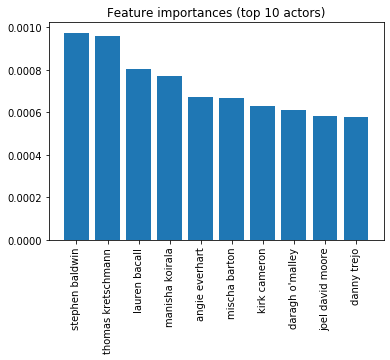

<Figure size 432x288 with 0 Axes>

In [0]:
print("Actor Feature Importance Ranking (Top 10):")

for f in range(10):
  idx = actor_indices[f]
  print(f + 1, feature_name[idx], importances[idx])

plt.figure()
plt.title("Feature importances (top 10 actors)")
plt.bar(range(10),importances[actor_indices[:10]])
plt.xticks(range(10), feature_name[actor_indices[:10]], rotation='vertical')
plt.show()
plt.savefig('drive/Shared drives/CS229Movie/FeatureImportance_Actor.eps')

Word in Overview Feature Importance Ranking (Top 30):
1   5.872537037501736e-06
2 recently 0.0
3 brought 0.0
4 different 0.0
5 kind 0.0
6 damage 0.0
7 grieving 0.0
8 father 0.0
9 spiral 0.0
10 innocence 0.0
11 stumbles 0.0
12 box 0.0
13 some 0.0
14 deceased 0.0
15 discovery 0.0
16 unknown 0.0
17 talent 0.0
18 forms 0.0
19 band 0.0
20 hope 0.0
21 finding 0.0
22 survivor 0.0
23 Josh 0.0
24 greatest 0.0
25 players 0.0
26 loss 0.0
27 arrives 0.0
28 teenage 0.0
29 apart 0.0
30 however 0.0


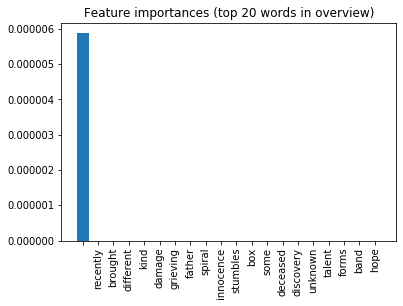

<Figure size 432x288 with 0 Axes>

In [0]:
print("Word in Overview Feature Importance Ranking (Top 30):")

for f in range(3, 33):
  idx = overview_indices[f]
  print(f -3 + 1, feature_name[idx], importances[idx])

plt.figure()
plt.title("Feature importances (top 20 words in overview)")
plt.bar(range(20),importances[overview_indices[3:23]])
plt.xticks(range(20), feature_name[overview_indices[3:23]], rotation='vertical')
plt.show()
plt.savefig('drive/Shared drives/CS229Movie/FeatureImportance_overview.eps')

In [0]:
print(size())